In [55]:
!pip install tensorflow

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

weather_df = pd.read_csv("wetter.csv")
kiwo_df = pd.read_csv("kiwo.csv")
sales_df = pd.read_csv("umsatzdaten_gekuerzt.csv")
holidays_df = pd.read_csv("../0_DataPreparation/holidays.csv")

print("Weather")
print(f" has {len(weather_df)} rows")
print(weather_df.head())
print("Kieler Woche")
print(f" has {len(kiwo_df)} rows")
print(kiwo_df.head())
print("Sales")
print(f" has {len(sales_df)} rows")
print(sales_df.head())
print("Holidays")
print(f" has {len(holidays_df)} rows")
print(holidays_df.head())

Weather
 has 2601 rows
        Datum  Bewoelkung  Temperatur  Windgeschwindigkeit  Wettercode
0  2012-01-01         8.0      9.8250                   14        58.0
1  2012-01-02         7.0      7.4375                   12         NaN
2  2012-01-03         8.0      5.5375                   18        63.0
3  2012-01-04         4.0      5.6875                   19        80.0
4  2012-01-05         6.0      5.3000                   23        80.0
Kieler Woche
 has 72 rows
        Datum  KielerWoche
0  2012-06-16            1
1  2012-06-17            1
2  2012-06-18            1
3  2012-06-19            1
4  2012-06-20            1
Sales
 has 9334 rows
        Datum  Warengruppe      Umsatz
0  2013-07-01            1  148.828353
1  2013-07-02            1  159.793757
2  2013-07-03            1  111.885594
3  2013-07-04            1  168.864941
4  2013-07-05            1  171.280754
Holidays
 has 577 rows
         date  summer  autumn  christmas  winter  easter  pentecoast
0  2013-06-24   

In [57]:
df = weather_df.merge(kiwo_df, on="Datum", how="left").merge(sales_df, on="Datum").merge(holidays_df, left_on="Datum", right_on="date", suffixes=("", "holiday_",))
df.fillna({"KielerWoche": 0, "holiday_sommer": 0, "holiday_autumn": 0, "holiday_christmas": 0, "holiday_winter": 0, "holiday_easter": 0, "holiday_pentecoast": 0}, inplace=True)
print(df.head())

        Datum  Bewoelkung  Temperatur  Windgeschwindigkeit  Wettercode  \
0  2013-07-01         6.0     17.8375                   15        20.0   
1  2013-07-01         6.0     17.8375                   15        20.0   
2  2013-07-01         6.0     17.8375                   15        20.0   
3  2013-07-01         6.0     17.8375                   15        20.0   
4  2013-07-01         6.0     17.8375                   15        20.0   

   KielerWoche  Warengruppe      Umsatz        date  summer  autumn  \
0          0.0            1  148.828353  2013-07-01       1       0   
1          0.0            2  535.856285  2013-07-01       1       0   
2          0.0            3  201.198426  2013-07-01       1       0   
3          0.0            4   65.890169  2013-07-01       1       0   
4          0.0            5  317.475875  2013-07-01       1       0   

   christmas  winter  easter  pentecoast  
0          0       0       0           0  
1          0       0       0           0  

In [58]:
df['Datum_dt'] = pd.to_datetime(df['Datum'])
df["StartOfMonth"] = np.where(df["Datum_dt"].dt.day < 7, 1, 0)

In [59]:
print("Unique Values:\n",df[["Wettercode", "Bewoelkung"]].apply(lambda x: x.unique()))

Unique Values:
 Wettercode    [20.0, nan, 61.0, 5.0, 21.0, 65.0, 63.0, 10.0,...
Bewoelkung        [6.0, 3.0, 7.0, 5.0, 0.0, 2.0, 1.0, 4.0, 8.0]
dtype: object


In [60]:
# Define categorical features
categorical_features = ['Warengruppe']

# Inspect data types and unique values for categorical columns
print(df[categorical_features].dtypes)
print("Unique Values:\n",df[categorical_features].apply(lambda x: x.unique()))

# Ensure categorical columns are treated as categories
for col in categorical_features:
    df[col] = df[col].astype('category')

# Encode categorical variables using pd.get_dummies
features = pd.get_dummies(df[categorical_features], drop_first=True, dtype=int)

# Include any numeric columns that are not categorical
for f in ["summer", "autumn", "StartOfMonth"]:
    features[f] = df[f]

# Construct the prepared data set including the dependent variable ('label')
prepared_data = pd.concat([df[['Umsatz', 'Datum_dt']], features], axis=1).dropna()

# Handle missing values by removing rows with any missing values
prepared_data = prepared_data.dropna()

# Display the shape of the prepared data set
print(prepared_data.shape)
# Display the first few rows of the prepared data set
prepared_data.head()

Warengruppe    int64
dtype: object
Unique Values:
    Warengruppe
0            1
1            2
2            3
3            4
4            5
5            6
(2184, 10)


,Umsatz,Datum_dt,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,summer,autumn,StartOfMonth
0,148.828353,2013-07-01,0,0,0,0,0,1,0,1
1,535.856285,2013-07-01,1,0,0,0,0,1,0,1
2,201.198426,2013-07-01,0,1,0,0,0,1,0,1
3,65.890169,2013-07-01,0,0,1,0,0,1,0,1
4,317.475875,2013-07-01,0,0,0,1,0,1,0,1


In [61]:
training_data = prepared_data[(prepared_data["Datum_dt"] >= "01.07.2013") & (prepared_data["Datum_dt"] <= "31.07.2017")]
validation_data = prepared_data[(prepared_data["Datum_dt"] >= "01.08.2017") & (prepared_data["Datum_dt"] <= "31.07.2018")]

print(f"Training Dataset length: {len(training_data)}")
print(f"Validation Dataset length: {len(validation_data)}")


print(training_data.dtypes)
training_data.sample()

Training Dataset length: 1694
Validation Dataset length: 605
Umsatz                  float64
Datum_dt         datetime64[ns]
Warengruppe_2             int64
Warengruppe_3             int64
Warengruppe_4             int64
Warengruppe_5             int64
Warengruppe_6             int64
summer                    int64
autumn                    int64
StartOfMonth              int64
dtype: object


,Umsatz,Datum_dt,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,summer,autumn,StartOfMonth
828,292.967838,2015-05-15,0,0,0,1,0,0,0,0


In [62]:
# Create subdirectory for the pickle files
import os

subdirectory = "pickle_data"
os.makedirs(subdirectory, exist_ok=True)

# Separating features and labels
training_features = training_data.drop(['Umsatz', 'Datum_dt'], axis=1)
validation_features = validation_data.drop(['Umsatz', 'Datum_dt'], axis=1)

training_labels = training_data[['Umsatz']]
validation_labels = validation_data[['Umsatz']]

# Export of the prepared data to subdirectory as pickle files
training_features.to_pickle(f"{subdirectory}/training_features.pkl")
validation_features.to_pickle(f"{subdirectory}/validation_features.pkl")
training_labels.to_pickle(f"{subdirectory}/training_labels.pkl")
validation_labels.to_pickle(f"{subdirectory}/validation_labels.pkl")

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
  InputLayer(input_shape=(training_features.shape[1], )),
  BatchNormalization(),
  Dense(10, activation='relu'),
  Dense(4, activation='relu'),
  Dense(1)
])

model.summary()

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_5           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 4)              │            44 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171 (684.00 B)

 Trainable params: 155 (620.00 B)

 Non-trainable params: 16 (64.00 B)

In [64]:
model.compile(loss="mse", optimizer=Adam(learning_rate=0.0001))

history = model.fit(training_features, training_labels, epochs=1000,
                    validation_data=(validation_features, validation_labels))

Epoch 1/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 103492.7266 - val_loss: 84106.1719
Epoch 2/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 107309.8516 - val_loss: 84088.8906
Epoch 3/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 99063.9062 - val_loss: 84072.2422
Epoch 4/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 99507.6641 - val_loss: 84054.0391
Epoch 5/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 102556.1250 - val_loss: 84035.0938
Epoch 6/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 104099.0781 - val_loss: 84014.8906
Epoch 7/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 101405.7734 - val_loss: 83993.5703
Epoch 8/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 96676.5000 - val_loss: 83969.4297
Epoch 9/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 105297.0547 - val_loss: 83943.3906
Epoch 10/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 101946.0234 - val_loss: 83915.8516
Epoch 11/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [65]:
model.save("python_model.h5")

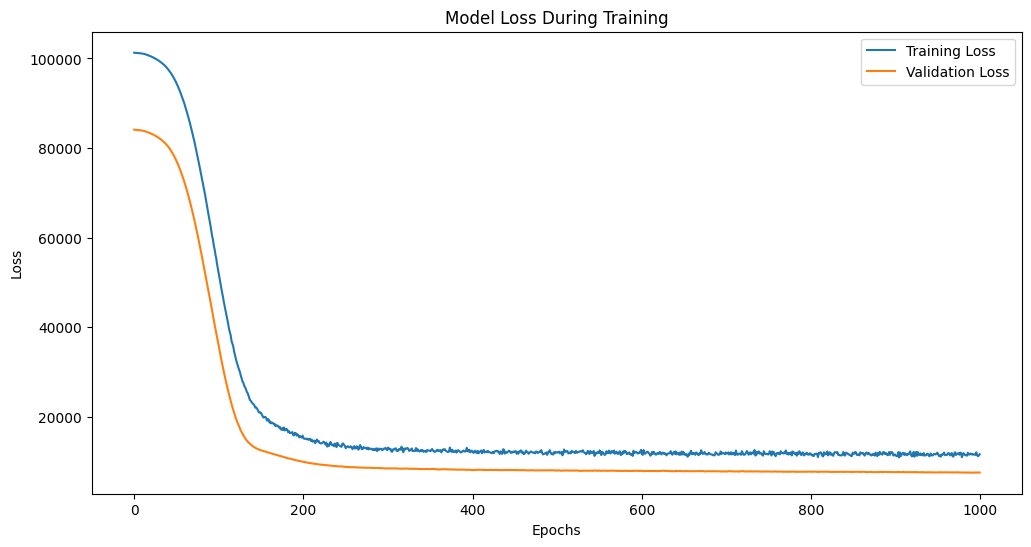

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [67]:
predict_val = model.predict(validation_features)
validation_features["Forecast"] = predict_val
validation_features["Diff"] = validation_features["Forecast"] - validation_labels["Umsatz"]
print(validation_features["Diff"])

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1579    -21.492602
1580    147.733833
1581     44.156267
1582     20.785782
1583    100.808379
           ...    
2179     69.897188
2180    -20.988221
2181     -0.211330
2182     35.942219
2183     92.485866
Name: Diff, Length: 605, dtype: float64


Text(0.5, 1.0, 'Comparison Actual Revenue vs. Forecast')

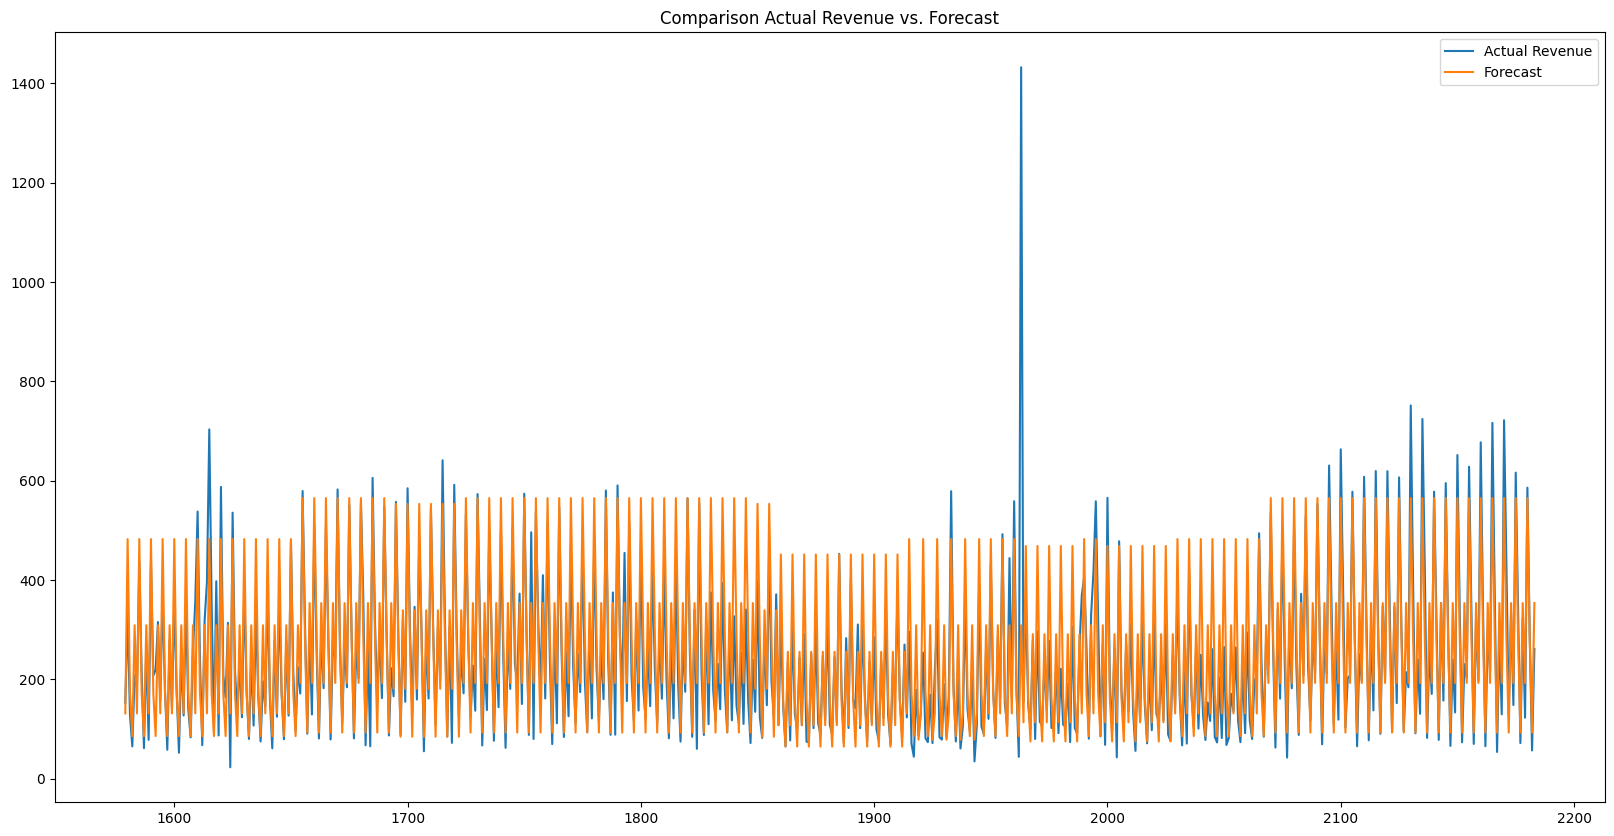

In [69]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.plot(validation_features.index, validation_labels["Umsatz"], label="Actual Revenue")
ax.plot(validation_features.index, validation_features["Forecast"], label="Forecast")
ax.legend(loc="upper right")
ax.set_title("Comparison Actual Revenue vs. Forecast")